<a href="https://colab.research.google.com/github/phantom-balance/TEP/blob/master/weekly_task_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM classification

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# Setting up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size=10

In [ ]:
train_dataset=datasets.MNIST(root='dataset/',train=True,transform=transforms.ToTensor(),download=True)
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
print("training_data's_shape:",train_dataset[1][0][0].shape) # Each data to be classified has 28 rows and 28 columns

training_data's_shape: torch.Size([28, 28])


In [ ]:
test_dataset=datasets.MNIST(root='dataset/',train=False,transform=transforms.ToTensor(),download=True)
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
print("testing_data's_shape:",test_dataset[1][0][0].shape) # Each data to be classified has 28 rows and 28 columns

testing_data's_shape: torch.Size([28, 28])


labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


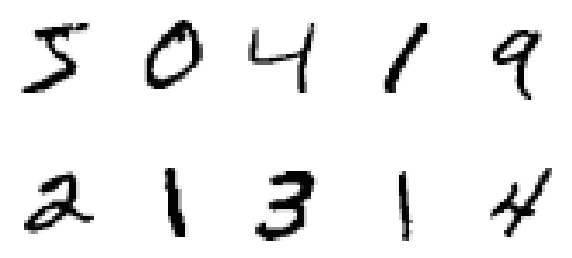

In [ ]:
plt.figure(figsize=(10,5))
label = []
for i in range(10):
  plt.subplot(2, 5, i+1)
  image, target = train_loader.dataset.__getitem__(i)
  label.append(target)
  plt.imshow(image.squeeze().numpy())
  plt.axis('off')
print("labels:",label)

# We will be assuming that each row from the 28 rows represents a unique time stamp. And each column of the 28 columns represents a unique feature. {FOR OUR LSTM MODEL}

In [ ]:
# Parameters
feature_size = 28
num_classes = 10
sequence_length = 28
num_hidden_layers = 2
hidden_units = 200
num_epochs = 2
learning_rate = 0.001

In [ ]:
# Model
class LSTM(nn.Module):
  def __init__(self, feature_size, sequence_length, hidden_units, num_hidden_layers, num_classes):
    super().__init__()
    self.sequence_length = sequence_length
    self.hidden_units = hidden_units
    self.num_hidden_layers = num_hidden_layers
    self.lstm = nn.LSTM(feature_size, hidden_units, num_hidden_layers, batch_first=True)
    self.fc = nn.Linear(hidden_units*sequence_length, num_classes)
#    self.fc = nn.Linear(hidden_units, num_classes) # only training on the step -1 state

  def forward(self, x):
    h0 = torch.zeros(self.num_hidden_layers,x.size(0),self.hidden_units).to(device=device)
    c0=torch.zeros(self.num_hidden_layers,x.size(0),self.hidden_units).to(device=device)

    out, _ = self.lstm(x,(h0, c0))
    out = out.reshape(out.shape[0],-1)
    out= self.fc(out)
    return out

In [ ]:
# Initializing model
model = LSTM(feature_size=feature_size,
             sequence_length=sequence_length,
             hidden_units=hidden_units,
             num_hidden_layers=num_hidden_layers,
             num_classes=num_classes).to(device)

In [ ]:
# Loss and Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

In [ ]:
k=0
for i in enumerate(train_loader):
  k+=1
print("training data instances:",k*batch_size)
k=0
for i in enumerate(test_loader):
  k+=1
print("testing data instances:",k*batch_size)

training data instances: 60000
testing data instances: 10000


In [ ]:
# Training entire training data in each epochs
num_epochs = 1
for epochs in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device).squeeze(1) # changing the shape to 28x28
    targets = targets.to(device)
    scores = model(data)
    loss = criterion(scores, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# # changing the shape to 28x28 in  #Training
# for batch_idx, (data, targets) in enumerate(train_loader):
#   if batch_idx==0:
#     print(data[1].shape)
#     data = data.to(device).squeeze(1)
#     print(data[1].shape)

In [ ]:
# Training in small chuncks(batch_size)
for i in range(50):
  data, targets = next(iter(train_loader))
  print('targets',targets)
  num_epochs = 3
  for epochs in range(num_epochs):
  #  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device).squeeze(1) # changing the shape to 28x28
    targets = targets.to(device)
    scores = model(data)
    loss = criterion(scores, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

targets tensor([3, 8, 4, 8, 6, 0, 1, 0, 0, 1])
targets tensor([2, 6, 9, 8, 7, 5, 8, 1, 0, 3])
targets tensor([2, 8, 2, 0, 5, 5, 1, 4, 4, 2])
targets tensor([1, 1, 5, 0, 6, 6, 5, 8, 1, 6])
targets tensor([7, 6, 1, 4, 5, 1, 3, 0, 1, 6])
targets tensor([7, 0, 9, 5, 3, 1, 3, 9, 9, 8])
targets tensor([5, 4, 4, 4, 2, 2, 1, 7, 9, 7])
targets tensor([9, 2, 0, 1, 2, 3, 0, 1, 5, 1])
targets tensor([3, 8, 0, 1, 4, 0, 4, 5, 5, 5])
targets tensor([1, 5, 5, 2, 8, 4, 8, 4, 7, 8])
targets tensor([8, 1, 0, 3, 9, 1, 8, 5, 5, 9])
targets tensor([7, 1, 3, 8, 3, 8, 5, 8, 4, 0])
targets tensor([7, 2, 5, 8, 4, 7, 0, 2, 5, 0])
targets tensor([5, 9, 9, 1, 0, 7, 4, 4, 7, 4])
targets tensor([7, 6, 5, 2, 0, 1, 5, 3, 2, 2])
targets tensor([7, 2, 2, 6, 6, 7, 9, 2, 8, 4])
targets tensor([8, 5, 2, 3, 7, 1, 9, 5, 5, 2])
targets tensor([1, 0, 7, 2, 7, 8, 2, 8, 7, 1])
targets tensor([8, 1, 1, 6, 7, 1, 3, 4, 0, 7])
targets tensor([1, 1, 0, 5, 9, 9, 7, 1, 3, 1])
targets tensor([5, 2, 6, 7, 7, 6, 7, 5, 5, 8])
targets tenso

actual_labels tensor([3, 4, 2, 6, 3, 3, 1, 8, 6, 2])
Got 9/10 correct, prediction rate=90.000
our_network's_prediction [tensor([3, 4, 2, 6, 3, 3, 1, 0, 6, 2])]


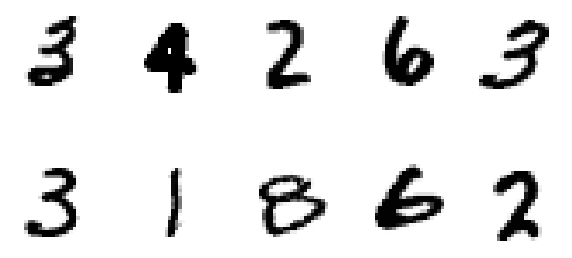

In [ ]:
# Accuracy testing
data, labelss = next(iter(test_loader))
print("actual_labels",labelss)
Predictions = []
def check_accuracy(data, targets, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
      x=data
      y=targets
      x=x.to(device=device).squeeze(1)
      y=y.to(device=device)
      scores=model(x)

      _, prediction= scores.max(1)
      Predictions.append(prediction)
      num_correct+=(prediction==y).sum()
      num_samples+=prediction.size(0)

    print(f'Got {num_correct}/{num_samples} correct, prediction rate={float(num_correct)/float(num_samples)*100:.3f}')
    model.train()

check_accuracy(data, labelss, model)
label = []
print("our_network's_prediction",Predictions)

plt.figure(figsize=(10,5))
for i in range(batch_size):
  plt.subplot(2, int(batch_size/2), i+1)
  plt.imshow(data[i].squeeze().numpy())
  label.append(targets)
  plt.axis('off')



#Performance metrics

1.1 confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

with torch.no_grad():
  for data, labels in test_loader:
    scores = model(data.squeeze(1))
    _, prediction = scores.max(1)
    y_pred.extend(prediction)
    y_true.extend(labels)
print(y_pred)
print(y_true)

# classes = ('NOC',
#            'fault_type-1', 
#            'fault_type-2', 
#            'fault_type-3',
#            'fault_type-4',
#            'fault_type-5',
#            'fault_type-6',
#            'fault_type-7',
#            'fault_type-8',
#            'fault_type-9',
#            'fault_type-10',
#            'fault_type-11',
#            'fault_type-12',
#            'fault_type-13',
#            'fault_type-14',
#            'fault_type-15',
#            'fault_type-16',
#            'fault_type-17',
#            'fault_type-18',
#            'fault_type-19',
#            'fault_type-20',
#            'fault_type-21'
#            )





[tensor(8), tensor(1), tensor(5), tensor(9), tensor(3), tensor(7), tensor(8), tensor(2), tensor(5), tensor(5), tensor(7), tensor(0), tensor(1), tensor(4), tensor(7), tensor(9), tensor(4), tensor(5), tensor(3), tensor(5), tensor(7), tensor(4), tensor(9), tensor(0), tensor(7), tensor(0), tensor(7), tensor(1), tensor(0), tensor(1), tensor(1), tensor(6), tensor(5), tensor(6), tensor(2), tensor(6), tensor(0), tensor(8), tensor(3), tensor(4), tensor(7), tensor(6), tensor(5), tensor(7), tensor(9), tensor(4), tensor(9), tensor(2), tensor(2), tensor(8), tensor(5), tensor(2), tensor(6), tensor(0), tensor(9), tensor(4), tensor(1), tensor(9), tensor(2), tensor(9), tensor(7), tensor(3), tensor(8), tensor(1), tensor(2), tensor(8), tensor(0), tensor(6), tensor(8), tensor(4), tensor(2), tensor(3), tensor(6), tensor(9), tensor(3), tensor(5), tensor(7), tensor(6), tensor(6), tensor(8), tensor(5), tensor(0), tensor(9), tensor(6), tensor(6), tensor(2), tensor(7), tensor(0), tensor(0), tensor(1), tensor(5)

In [ ]:
from sklearn.metrics import confusion_matrix
classes = ('0',
           '1',
           '2',
           '3',
           '4',
           '5',
           '6',
           '7',
           '8',
           '9'
           )

cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[ 968    0    0    0    0    2    6    1    2    1]
 [   0 1106    6    3    0    2    3    1   14    0]
 [  12    0  970   11    4    4    9   12   10    0]
 [   0    0   17  951    0   18    0   14    5    5]
 [   2    1    2    0  919    4   13    3    5   33]
 [   4    3    0   15    1  839    9    5   12    4]
 [  10    3    3    1    2    8  930    0    1    0]
 [   1    9   34    0    0    2    0  965    0   17]
 [   7    1   11    7    2   32    5   13  891    5]
 [   5    5    6   12   31   27    1   10    6  906]]


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
classes = ('0',
           '1',
           '2',
           '3',
           '4',
           '5',
           '6',
           '7',
           '8',
           '9'
           )

cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[[8979   41]
  [  12  968]]

 [[8843   22]
  [  29 1106]]

 [[8889   79]
  [  62  970]]

 [[8941   49]
  [  59  951]]

 [[8978   40]
  [  63  919]]

 [[9009   99]
  [  53  839]]

 [[8996   46]
  [  28  930]]

 [[8913   59]
  [  63  965]]

 [[8971   55]
  [  83  891]]

 [[8926   65]
  [ 103  906]]]


In [ ]:
## for mulitclass only, 
# print("precision_score:", precision_score(y_true, y_pred, average='micro'))
# print("recall_score:", recall_score(y_true, y_pred, average='micro'))

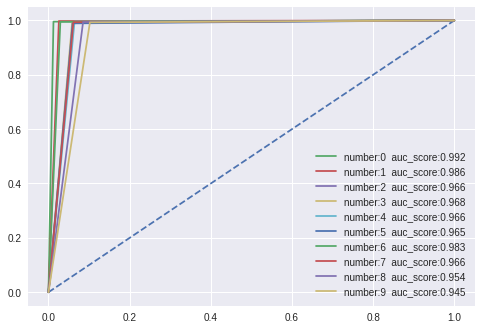

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score

plt.style.use('seaborn')
plt.plot([0,1], [0,1], '--')
#Binary mode for each class
for i in range(10):
  y_true_temp=y_true.copy()
  y_pred_temp=y_pred.copy()
  for j in range(len(y_true)):
    if y_true_temp[j]==i:
      y_true_temp[j]= torch.tensor(0)
    else :
      y_true_temp[j]=torch.tensor(1)
    if y_pred_temp[j]==i:
      y_pred_temp[j]= torch.tensor(0)
    else :
      y_pred_temp[j]=torch.tensor(1)  
    
  fpr, tpr, thresholds = roc_curve(y_true_temp, y_pred_temp)
  roc_auc = roc_auc_score(y_true_temp, y_pred_temp)
  plt.plot(fpr, tpr, label="number:"+str(i)+"  auc_score:"+str(f'{float(roc_auc):.3f}'))
  # print("precision_score_for_number"+str(i)+":"+str(precision_score(y_true_temp, y_pred_temp)))
  # print("recall_score_for_number"+str(i)+":"+str(recall_score(y_true_temp, y_pred_temp)))
  # print("f1_score_for_number"+str(i)+":"+str(f1_score(y_true_temp, y_pred_temp)))
  # print("###########################################################")
plt.legend(loc='lower right')


0.875


Text(0, 0.5, 'true positive rate')

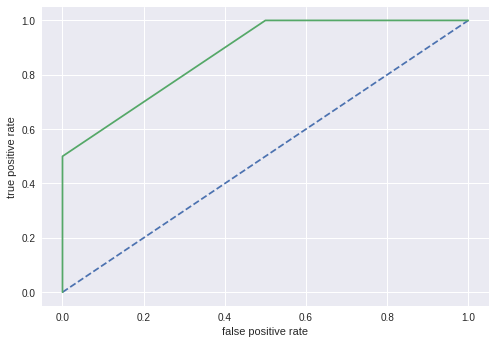

In [ ]:
actual=[0,0,1,1,1,1,0,0]
predic=[0.1,0.8,0.1,0.8,1,1,0,0] # this should be probability hai
fpr, tpr, threshold = roc_curve(actual, predic)
auc_score = roc_auc_score(actual, predic)
#print(confusion_matrix(actual, predic))
print(auc_score)
plt.plot([0,1], [0,1], ls='--')
plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')